In [1]:
'''Import Relevant Modules'''

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
'''Get the images to train the model on'''
X = []
for filename in os.listdir('../Datasets/Train/'):
    X.append(img_to_array(load_img('../Datasets/Train/'+filename)))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [3]:
'''Construct the model with tensorflow layers'''
''' credit to Emil Wallner'''
model = Sequential()
#change this line if image size is different 
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [4]:
'''credit to Emil Wallner'''
# Use this function to generate more training data
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [9]:
'''Train the model - Takes anywhere from 30 mins to 1 hr. Can skip this cell to load a previously run model''' 
'''credit to Emil Wallner'''
# model.fit_generator(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1000)

'Train the model - Takes anywhere from 30 mins to 1 hr. Can skip this cell to load a previously run model'

In [5]:
'''Saving and loading of the model. To save a model after running the cell above, uncomment lines 3-4'''


# model.save('model_main.h5')
# print('Model Saved!')
 
# load an already trained model
savedModel=load_model('model_main.h5')
# print a summary of the model
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [10]:
'''Now use the rest of the images to evaluate the model's performance'''
'''credit to Emil Wallner'''
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(savedModel.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 76ms/step - loss: 0.0096
0.009562723338603973


# Figure 1: Recolored Images

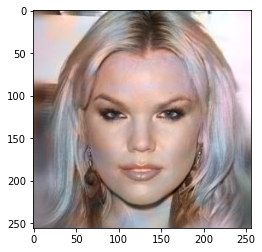

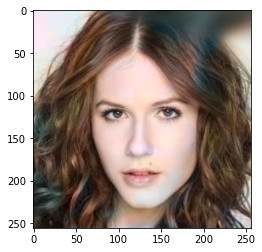

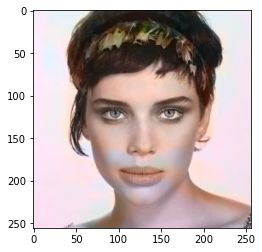

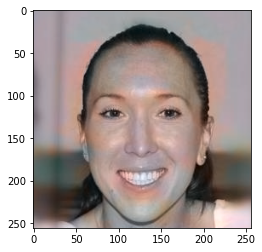

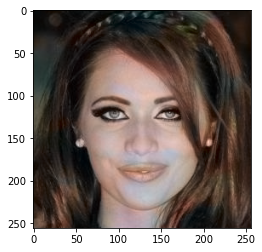

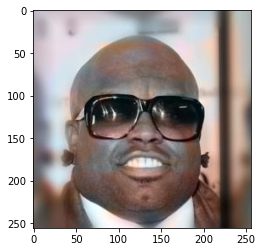

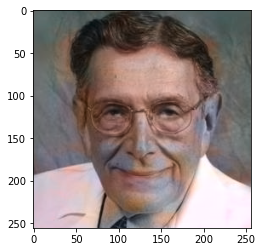

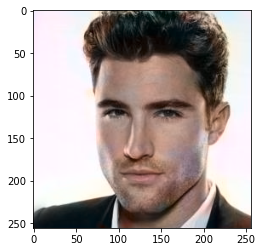

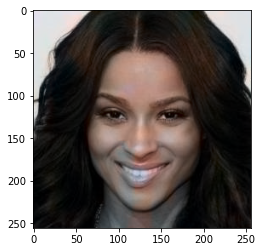

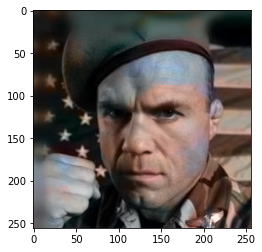

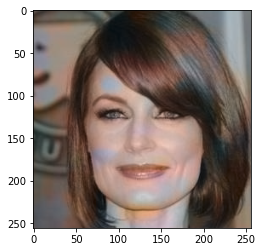

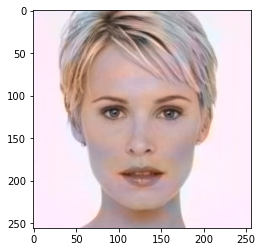

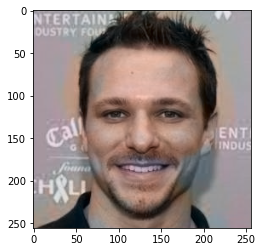

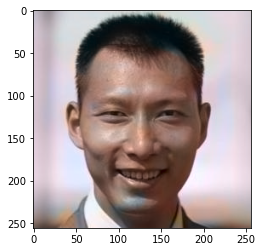

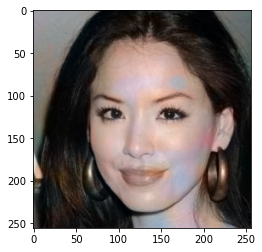

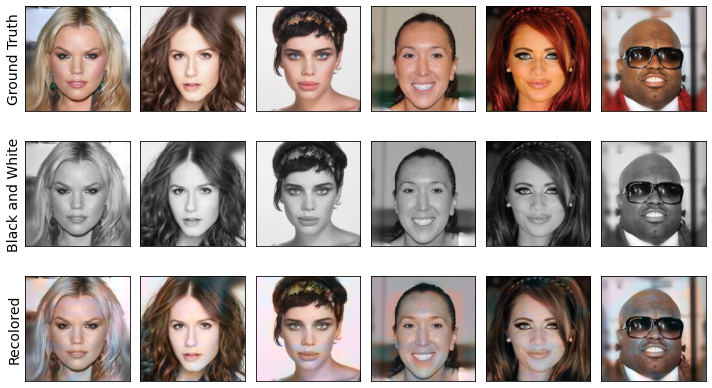

In [11]:
'''The following code is what was used to produce figure 1 in the report'''


# load in the test images
os.chdir('../Datasets/Test Images/')
holder = glob.glob("*")
test_set = []
for filename in holder:
    data = img_to_array(load_img(filename))
    test_set.append(data)
os.chdir('../../Model/')
test_set_groundtruth = np.array(np.copy(test_set), dtype=float)/255

# load in the black and white versions of the above images
os.chdir('../Datasets/Test Images BW/')
holder = glob.glob("*")
real_BW = []
for filename in holder:
    data = img_to_array(load_img(filename))
    real_BW.append(data)
os.chdir('../../Model/')
real_BW = np.array(np.copy(real_BW), dtype=float)/255

# convert the images to lab and prepare them to be run through the model
test_set_BW = rgb2lab(1.0/255*np.copy(test_set))[:,:,:,0]
test_set_BW = test_set_BW.reshape(test_set_BW.shape+(1,))

# run the images through the model
output = savedModel.predict(test_set_BW)
output = output * 128

# reconstruct the images and convert back to RGB to be visualized
test_set_recolored = []
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = test_set_BW[i][:,:,0]
    cur[:,:,1:] = output[i]
    test_set_recolored.append(lab2rgb(cur))
    plt.imshow(lab2rgb(cur))
    plt.show()
    
# create figure 1
num_imgs = 6

fig, ax = plt.subplots(3, num_imgs, figsize = (10,6))

for i in range(num_imgs):
    ax[0,i].imshow(test_set_groundtruth[i])
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[0,i].get_yticklabels(), visible=False)
    ax[0,i].tick_params(axis='both', which='both', length=0)

    ax[1,i].imshow(real_BW[i])
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_yticklabels(), visible=False)
    ax[1,i].tick_params(axis='both', which='both', length=0)

    ax[2,i].imshow(test_set_recolored[i])
    plt.setp(ax[2,i].get_xticklabels(), visible=False)
    plt.setp(ax[2,i].get_yticklabels(), visible=False)
    ax[2,i].tick_params(axis='both', which='both', length=0)



ax[0,0].set_ylabel('Ground Truth', fontsize = 14)
ax[1,0].set_ylabel('Black and White', fontsize = 14)
ax[2,0].set_ylabel('Recolored', fontsize = 14)

plt.tight_layout()
plt.show()

# Figure 2: Missing Info

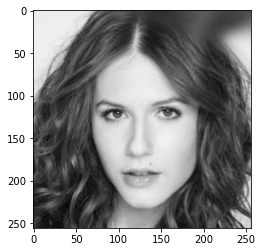

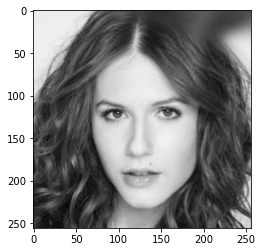

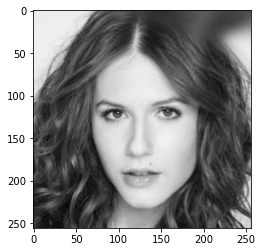

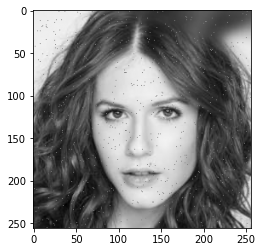

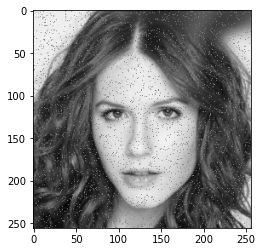

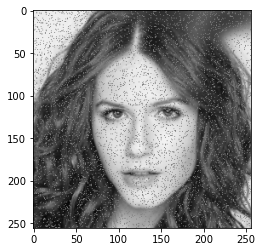

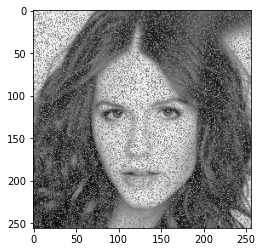

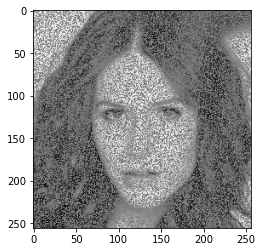

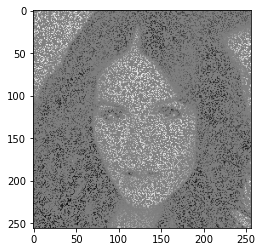

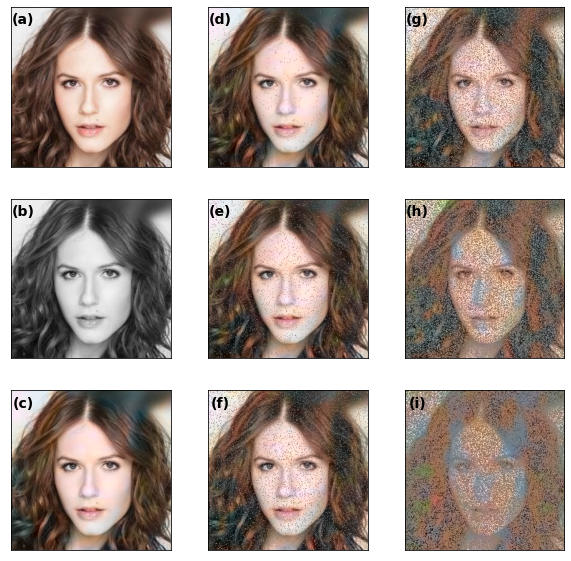

In [12]:
'''The following code is what was used to produce figure 2 in the report'''

# use this image for the next few steps since it looked the best out of all the test images
new_img = np.copy(real_BW[1])

# a method to perform the pixel loss method outlined in the paper
def loss_of_info(img, percent, pixel_value):
    # dont even bother trying to edit more that 100% of the image
    if percent > 1:
        return
    
    # perform pixel changes until the percentage is reached
    count = 0
    while count < int(len(img)**2*percent):
        
        # pick out random pixel values within the image
        rand1, rand2 = np.random.randint(0, len(img)), np.random.randint(0, len(img[0]))
        
        # the each RGB component is already exaclty equal to pixel_value, then pass over it
        if img[rand1][rand2][0] == pixel_value and img[rand1][rand2][1] == pixel_value and img[rand1][rand2][2] == pixel_value:
            pass
        else:
            img[rand1][rand2][0] = pixel_value
            img[rand1][rand2][1] = pixel_value
            img[rand1][rand2][2] = pixel_value
            count += 1
    return img


# a list of values to be tested. The first two are just placeholders for the black and white and original image
percents = [0,0,0,0.01,0.05,0.1,0.25,0.5,0.75]

test_imgs = []
for i in percents:
    test_imgs.append(loss_of_info(np.copy(new_img), i, 0.5))

for i in test_imgs:
    plt.imshow(i)
    plt.show()
    
    
    
# create figure 2
color_me = np.array(test_imgs, dtype=float)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = savedModel.predict(color_me)
output = output * 128

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
fig, ax = plt.subplots(3, 3, figsize = (10,10))
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    if i < 3:
        if i == 0:
            ax[i,0].imshow(test_set_groundtruth[1])
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        elif i == 1:
            ax[i,0].imshow(real_BW[1])
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        else:
            ax[i,0].imshow(lab2rgb(cur))
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        
    elif i < 6:
        ax[i-3,1].imshow(lab2rgb(cur))
        ax[i-3,1].xaxis.set_visible(False)
        ax[i-3,1].yaxis.set_visible(False)
        plt.text(0.08, 0.92,labels[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = ax[i-3,1].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
    else:
        ax[i-6,2].imshow(lab2rgb(cur))
        ax[i-6,2].xaxis.set_visible(False)
        ax[i-6,2].yaxis.set_visible(False)
        plt.text(0.08, 0.92,labels[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = ax[i-6,2].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')


plt.show()

    

# Figure 3: Performance Plot

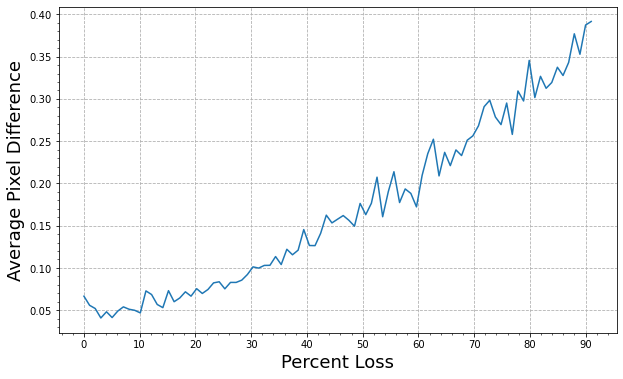

In [14]:
'''The following code is what was used to produce figure 3 in the report'''

# generate a bunch of values to be tested by the method
percents = np.linspace(0, .9, 91)
plots = []
for i in percents:
    plots.append(loss_of_info(np.copy(new_img), i, 0.5))
    

    color_me = np.array(plots, dtype=float)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = savedModel.predict(color_me)
output = output * 128

scores = []
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    diff = np.array(test_set_groundtruth[1] - lab2rgb(cur))
    result = np.average(np.sqrt(abs(np.dot(diff[:][:][0], np.transpose(diff[:][:][0])))))
    scores.append(result)


# create figure 3
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(np.linspace(0, len(scores), len(scores)), scores)
plt.xlabel('Percent Loss', fontsize = 18)
plt.ylabel('Average Pixel Difference', fontsize = 18)

majorLocator = MultipleLocator(10)
majorFormatter = FormatStrFormatter('%.0f')
minorLocator = MultipleLocator(2)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(0.05)
majorFormatter = FormatStrFormatter('%.2f')
minorLocator = MultipleLocator(0.01)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

plt.grid(True, linestyle = '--')
plt.show()

# Figure 4: Random Noise

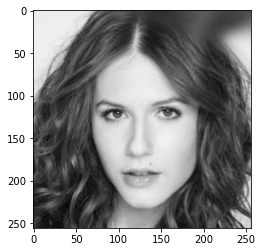

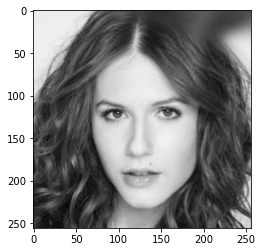

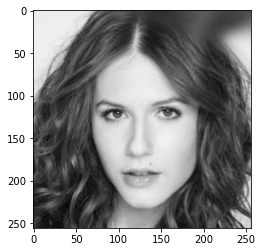

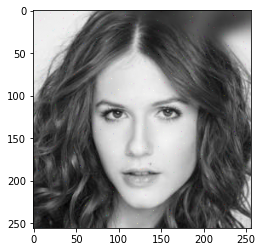

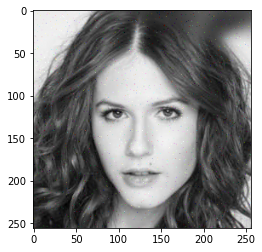

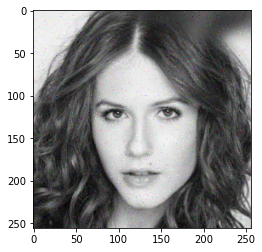

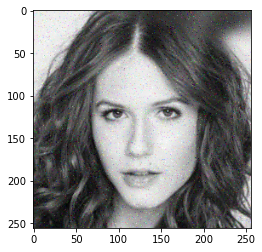

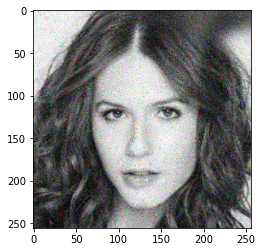

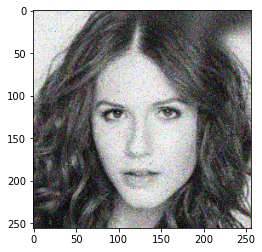

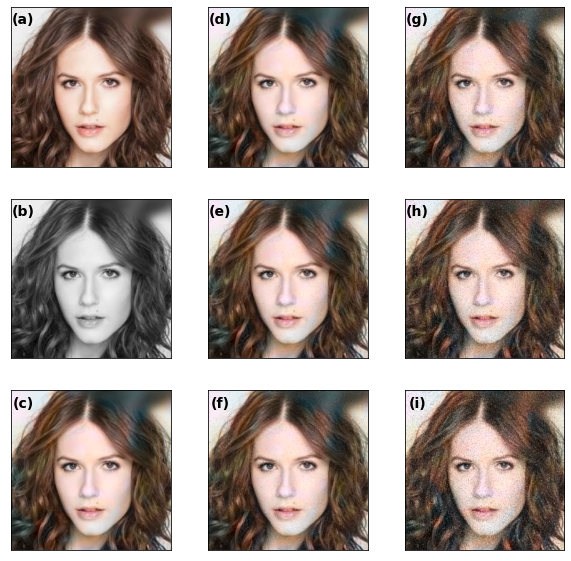

In [15]:
'''The following code is what was used to produce figure 4 in the report'''

# ideally keep percent to lower that 75% since it takes a while
def random_loss(img, percent):
    # don't run if asked unreasonable percentage
    if percent >= 1:
        return
    count = 0
    while count < int(len(img)**2*percent):
        # randomly select pixels to ass noise to
        rand1, rand2 = np.random.randint(0, len(img)), np.random.randint(0, len(img[0]))
        
        # add 'noise' to the pixel values dictated by the strength parameter (randint used to make some negative)
        x = 0.25 * np.random.randint(-1,2) * np.random.rand()
        
        if img[rand1][rand2][0] + x > 1:
            img[rand1][rand2][0] = 1
        elif img[rand1][rand2][0] + x < 0:
            img[rand1][rand2][0] = 0
        else:
            img[rand1][rand2][0] += x
            
        y = 0.25 * np.random.randint(-1,2) * np.random.rand()
        
        if img[rand1][rand2][1] + y > 1:
            img[rand1][rand2][1] = 1
        elif img[rand1][rand2][1] + y < 0:
            img[rand1][rand2][1] = 0
        else:
            img[rand1][rand2][1] += y
            
        z = 0.25 * np.random.randint(-1,2) * np.random.rand()
        
        if img[rand1][rand2][2] + z > 1:
            img[rand1][rand2][2] = 1
        elif img[rand1][rand2][2] + z < 0:
            img[rand1][rand2][2] = 0
        else:
            img[rand1][rand2][2] += z
     
        count += 1
    return img



percents = [0,0,0,0.01,0.05,0.1,0.25,0.5,0.75]

test_imgs = []
for i in percents:
    test_imgs.append(random_loss(np.copy(new_img), i))

for i in test_imgs:
    plt.imshow(i)
    plt.show()
    

# create figure 4
color_me = np.array(test_imgs, dtype=float)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = savedModel.predict(color_me)
output = output * 128

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
fig, ax = plt.subplots(3, 3, figsize = (10,10))
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    if i < 3:
        if i == 0:
            ax[i,0].imshow(test_set_groundtruth[1])
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        elif i == 1:
            ax[i,0].imshow(real_BW[1])
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        else:
            ax[i,0].imshow(lab2rgb(cur))
            ax[i,0].xaxis.set_visible(False)
            ax[i,0].yaxis.set_visible(False)
            plt.text(0.08, 0.92,labels[i],
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = ax[i,0].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
        
    elif i < 6:
        ax[i-3,1].imshow(lab2rgb(cur))
        ax[i-3,1].xaxis.set_visible(False)
        ax[i-3,1].yaxis.set_visible(False)
        plt.text(0.08, 0.92,labels[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = ax[i-3,1].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')
    else:
        ax[i-6,2].imshow(lab2rgb(cur))
        ax[i-6,2].xaxis.set_visible(False)
        ax[i-6,2].yaxis.set_visible(False)
        plt.text(0.08, 0.92,labels[i],
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform = ax[i-6,2].transAxes, color = 'black', fontsize = 14, fontweight = 'bold')


plt.show()
    

# Figure 5: Performance Plot

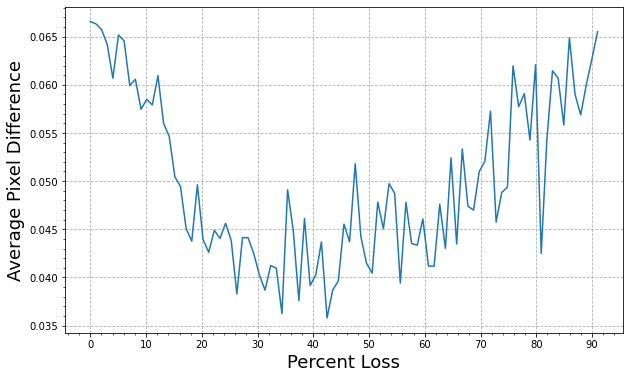

In [16]:
'''The following code is what was used to produce figure 5 in the report'''

percents2 = np.linspace(0, .9, 91)
plots2 = []
for i in percents2:
    plots2.append(random_loss(np.copy(new_img), i))

color_me2 = np.array(plots2, dtype=float)
color_me2 = rgb2lab(color_me2)[:,:,:,0]
color_me2 = color_me2.reshape(color_me2.shape+(1,))

# Test model
output2 = savedModel.predict(color_me2)
output2 = output2 * 128

scores2 = []
for i in range(len(output2)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me2[i][:,:,0]
    cur[:,:,1:] = output2[i]
    diff2 = np.array(test_set_groundtruth[1] - lab2rgb(cur))
    result2 = np.average(np.sqrt(abs(np.dot(diff2[:][:][0], np.transpose(diff2[:][:][0])))))
    scores2.append(result2)

    
# create figure 5
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(np.linspace(0, len(scores2), len(scores2)), scores2)

plt.xlabel('Percent Loss', fontsize = 18)
plt.ylabel('Average Pixel Difference', fontsize = 18)

majorLocator = MultipleLocator(10)
majorFormatter = FormatStrFormatter('%.0f')
minorLocator = MultipleLocator(2)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(0.005)
majorFormatter = FormatStrFormatter('%.3f')
minorLocator = MultipleLocator(0.001)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

plt.grid(True, linestyle = '--')
plt.show()